<a href="https://colab.research.google.com/github/plaban1981/Pytorch_lightning/blob/main/Pneumonia_Classification_Challenge_by_Segmind_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os

## Download Images

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY',
                                    dest_path='content/pneumonia_dataset.zip',
                                    unzip=True)

Unzipping...Done.


## Import pytorch lightning

In [3]:
import torch
print(torch.__version__)

1.8.1+cu101


In [4]:
%%capture 
!pip install pytorch-lightning

In [5]:
import pytorch_lightning as pl
print(pl.__version__)

1.2.10


In [6]:
%%capture
!pip install timm

In [7]:
%%capture 
!pip install albumentations==0.4.6

In [8]:
import albumentations
albumentations.__version__

'0.4.6'

##Image Classification

In [9]:
import os
import albumentations
from albumentations.pytorch import ToTensorV2
#
import pandas as pd
import numpy as np
from sklearn.metrics import *
#
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from torch.utils.data import TensorDataset,Dataset,DataLoader
#
import cv2
from PIL import Image
from PIL import ImageFilter
#
import pytorch_lightning as pl
from pytorch_lightning import metrics
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
#
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CometLogger
# 
import warnings
warnings.filterwarnings('ignore')

In [10]:
image_folder = os.listdir("/content/content/pneumonia_dataset/train")
filename = []
label = []
for folder in image_folder:
  for image_name in os.listdir(os.path.join("/content/content/pneumonia_dataset/train",folder)):
    filename.append("train/"+folder+"/"+image_name)
    label.append(folder)

##Train data

In [11]:
train_df = pd.DataFrame({'filename':filename,'label':label})
train_df.head()

,filename,label
0,train/normal/CXR_train_1184.png,normal
1,train/normal/CXR_train_447.png,normal
2,train/normal/CXR_train_1746.png,normal
3,train/normal/CXR_train_549.png,normal
4,train/normal/CXR_train_558.png,normal


In [12]:
train_df.to_csv("/content/content/pneumonia_dataset/train.csv",index=False)

## Viusalize Labels

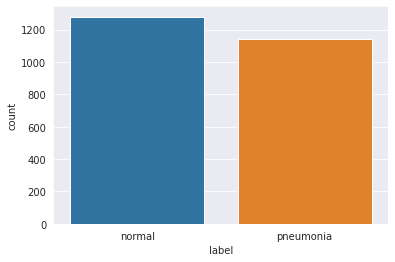

In [ ]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=train_df)

## Helper Functions

In [73]:
def visualize(images, transform):
    """
    Plot images and their transformations
    """
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

In [74]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [75]:
train_df.head()

,filename,label
0,train/normal/CXR_train_1184.png,normal
1,train/normal/CXR_train_447.png,normal
2,train/normal/CXR_train_1746.png,normal
3,train/normal/CXR_train_549.png,normal
4,train/normal/CXR_train_558.png,normal


## Visualize sample Data

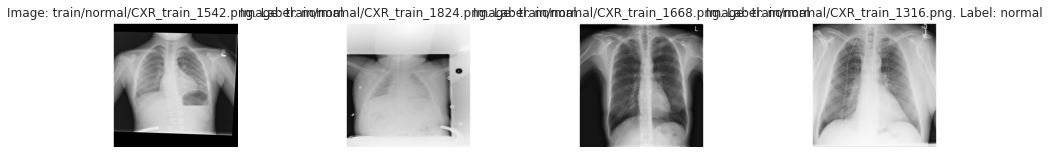

In [87]:
selected_images = []
path = "/content/content/pneumonia_dataset/"
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    for i, (idx, row) in enumerate(train_df.loc[train_df['label'] == "normal"].sample(4).iterrows()):
        ax = fig.add_subplot(6, 4, 1* 4 + i + 1, xticks=[], yticks=[])
        img = cv2.imread(f"{path}{row['filename']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        ax.set_title(f"Image: {row['filename']}. Label: {row['label']}")
        if i == 0:
            selected_images.append(img)

## Original Images

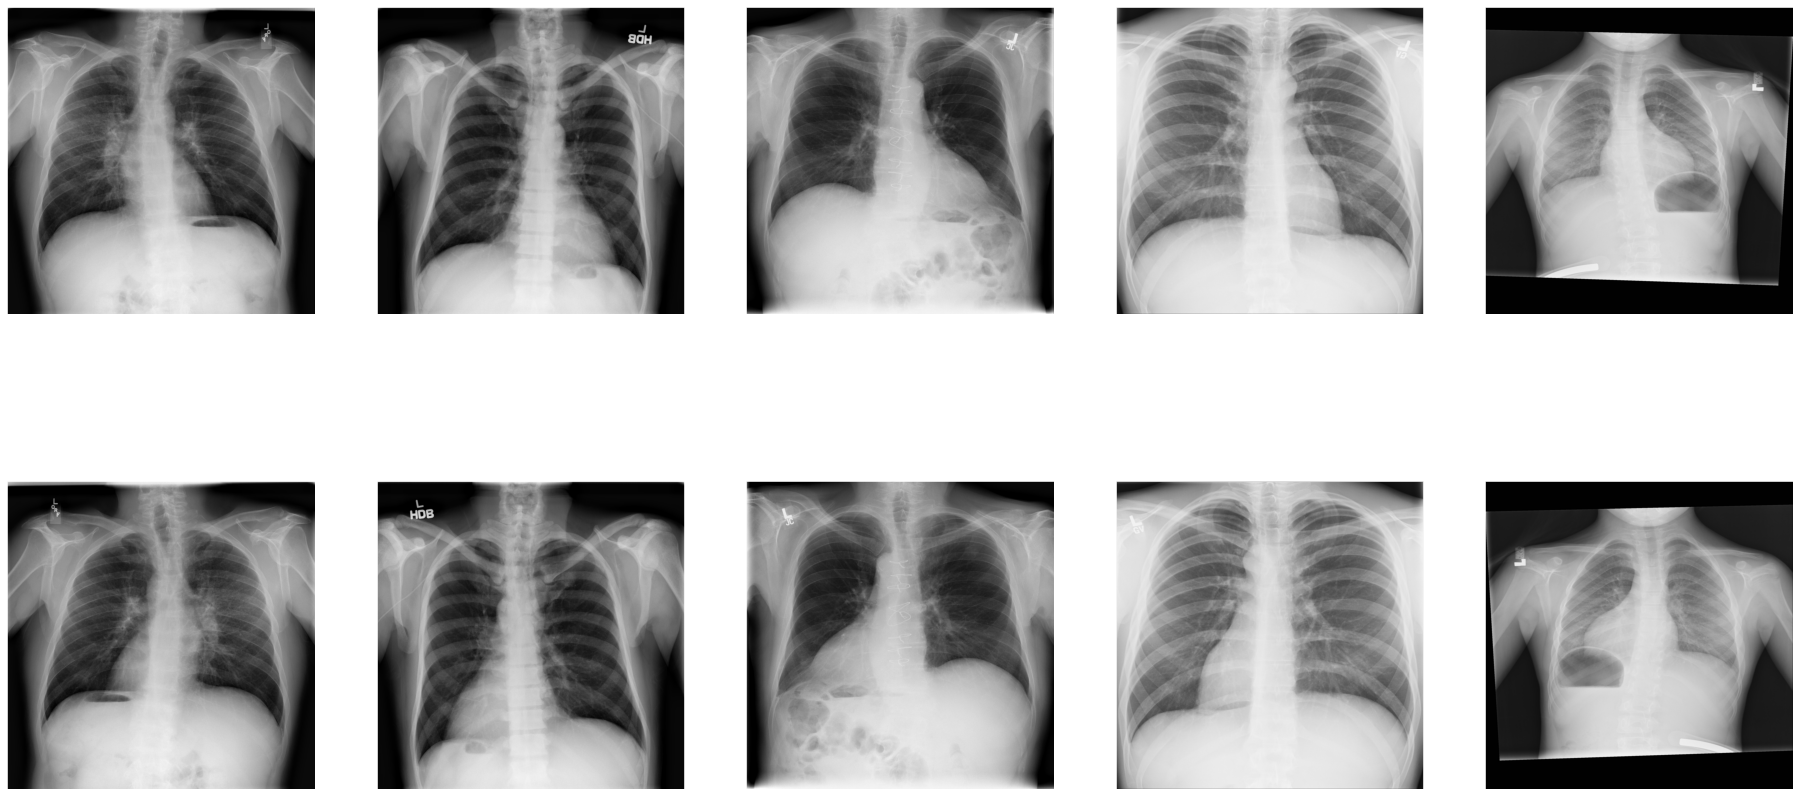

In [88]:
visualize(selected_images, A.HorizontalFlip(p=1))

## Augmented Images

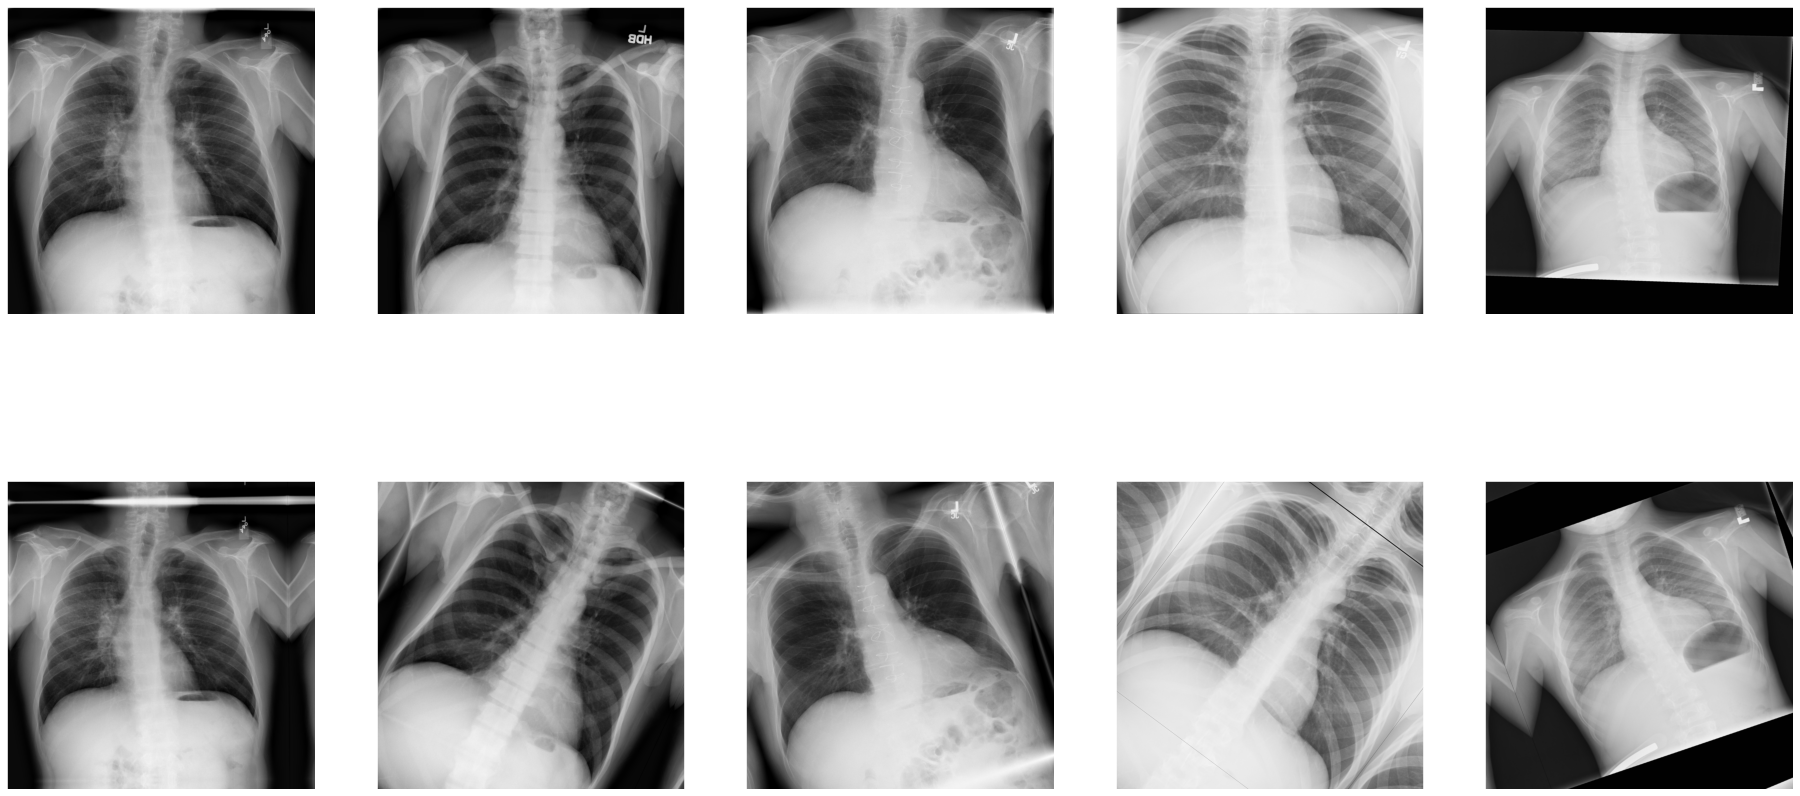

In [89]:
visualize(selected_images, A.ShiftScaleRotate(p=1))

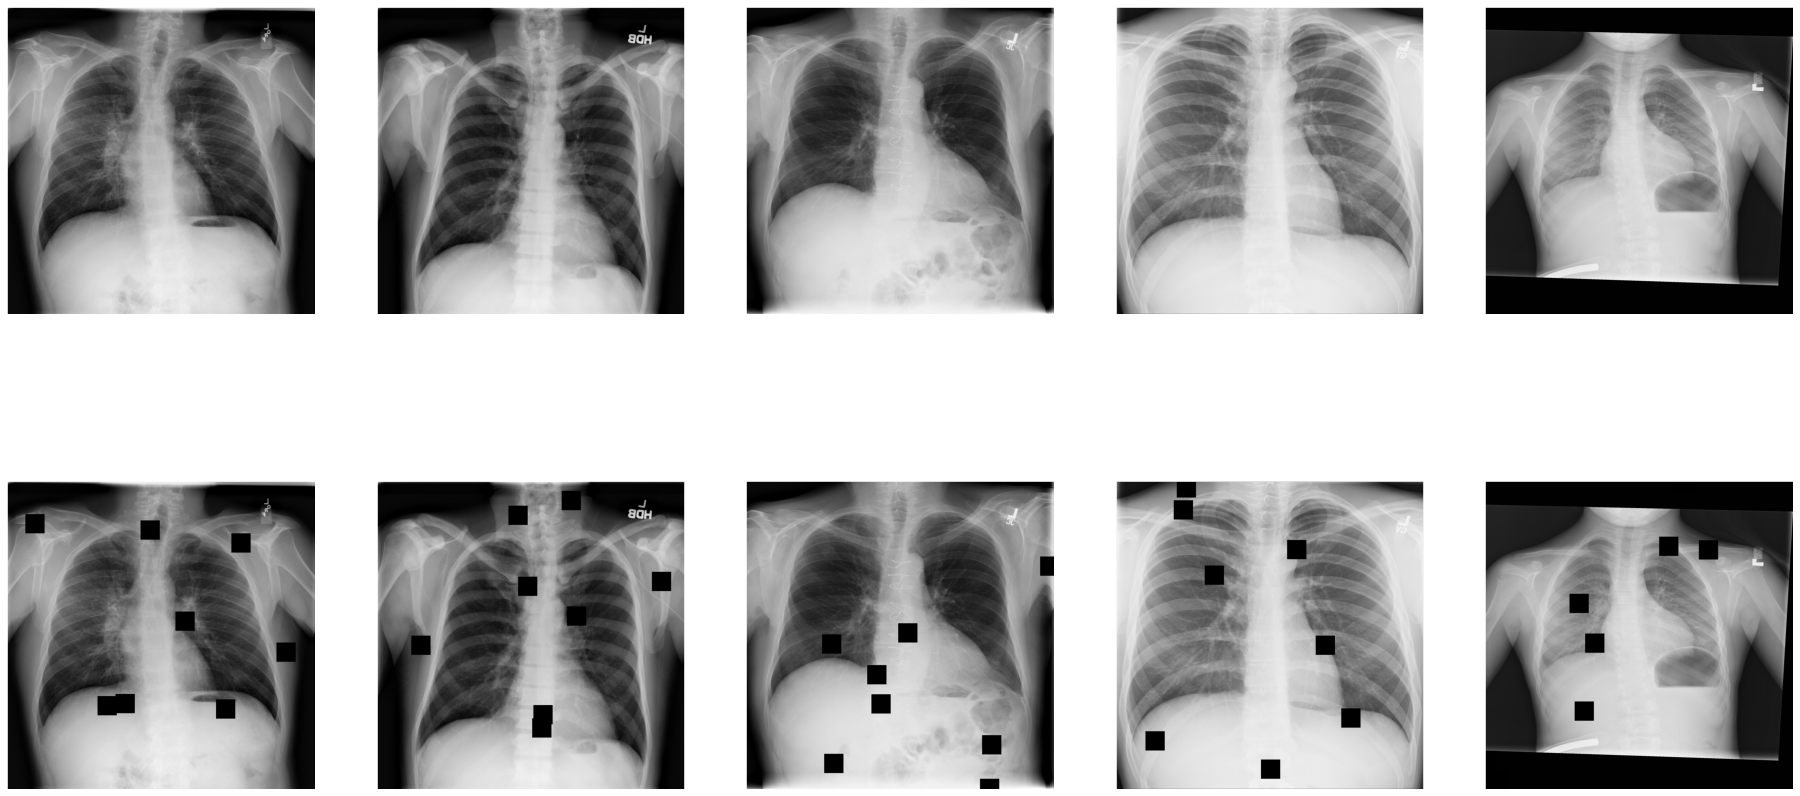

In [90]:
visualize(selected_images, A.Cutout(max_h_size=64, max_w_size=64, p=1))

In [13]:
train = train_df.copy()

In [14]:
train.label.unique()

array(['normal', 'pneumonia'], dtype=object)

In [15]:
label_dict = {'normal':0,'pneumonia':1}

In [16]:
train['label'] = train['label'].map(label_dict)
train.head()

,filename,label
0,train/normal/CXR_train_1184.png,0
1,train/normal/CXR_train_447.png,0
2,train/normal/CXR_train_1746.png,0
3,train/normal/CXR_train_549.png,0
4,train/normal/CXR_train_558.png,0


In [17]:
train.to_csv("/content/content/pneumonia_dataset/train.csv",index=False)

## Preparing classes for pytorch-lightning

In [18]:
class Data(Dataset):
    def __init__(self, dataframe, transform, target):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
        self.target = target
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, item):
      boats = self.dataframe.iloc[item]['label']
      img_id = self.dataframe.iloc[item]['filename']
      img_path = "/content/content/pneumonia_dataset/"+img_id
      target = self.target[item]
      image = cv2.imread(img_path, 1)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      if self.transform is not None:
        image = self.transform(image = image)['image']

      return image, torch.tensor(target)

## Image Augmentation

In [19]:
train_aug = albumentations.Compose([
            # albumentations.RandomResizedCrop(320,320),
            albumentations.RandomResizedCrop(384,384), #use bigger size images, as it makes easier for you cnn to capture hidden features, and don't think that the image will become blurry, this is not a problem for cnns
            albumentations.CLAHE(p = 0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
            ])
  
        
valid_aug = albumentations.Compose([
            albumentations.Resize(384,384),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
])

In [20]:
class NF_Net(nn.Module):
    def __init__(self, num_classes,pretrained = True):
        super().__init__()
        self.cnn = timm.create_model(model_name = 'resnet152d', pretrained=pretrained)
        self.classifier = nn.Sequential(nn.Dropout(0.1),
                                    nn.LeakyReLU(),
                                    nn.Linear(1000,num_classes))
        
    def forward(self, x):
        output = self.cnn(x)
        output = self.classifier(output)
        return output

In [46]:
class CNNClassifier(pl.LightningModule):
  def __init__(self, train_dataset, val_dataset, learning_rate = None, batch_size = 16):
    super().__init__()
    #model
    self.net = NF_Net(num_classes=2)
 
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.save_hyperparameters()

    self.train_acc_metric = pl.metrics.classification.F1(num_classes =2,average='weighted')
    self.valid_acc_metric = pl.metrics.classification.F1(num_classes =2,average='weighted')

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

  def forward(self, x):
    x = self.net(x)
    return x

  #use any optimizer and schedular you want (Adam and AdamW are mostly used)
  #for ReduceLROnPlateau you have to also pass the monitor metric

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    #this is my go to schedular, works quite well in every scenario
    schedular = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1
        )
    # schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, 
    #                                                        threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08, verbose = True)
    return {
        "optimizer":optimizer,
        "schedular":schedular,
        # "monitor":"val_loss_epoch" #for ReduceLROnPlateau
    }

  def training_step(self, batch, batch_idx):
    image, targets = batch
    y_pred = self.forward(image)
    loss = F.binary_cross_entropy_with_logits(y_pred, targets.type_as(y_pred)) #Note: Here I've used binary cross entropy with sigmoid activation loss, I also tried the cross entropy, but this seemed to converge a lot faster
    train_acc_batch = self.train_acc_metric(torch.sigmoid(y_pred), targets)
    self.log('train_acc_batch', train_acc_batch, prog_bar = True)
    self.log('train_loss_batch', loss)
    return {
        'loss': loss,
        'y_pred': y_pred,
        'y_true': targets
    }

  def training_epoch_end(self, outputs):
      current_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
      train_acc = self.train_acc_metric.compute()
      print(f"Training_ACC: {train_acc}")
      self.log('Training_loss_epoch', current_train_loss)
      self.log('Training_acc_epoch', train_acc)

  def validation_step(self, batch, batch_idx):
      image, targets = batch
      y_pred = self.forward(image)
      loss = F.binary_cross_entropy_with_logits(y_pred, targets.type_as(y_pred))
      val_acc_batch = self.valid_acc_metric(torch.sigmoid(y_pred), targets)
      self.log('val_acc_batch', val_acc_batch)
      self.log('val_loss_batch', loss)
      return {
          'val_loss': loss,
          'y_pred': y_pred,
          'target': targets
      }

  def validation_epoch_end(self, outputs):
        current_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_acc = self.valid_acc_metric.compute()
        print(f"Validation_ACC: {val_acc}")
        self.log("validation_loss_epoch", current_val_loss)
        self.log('Validation_acc_epoch', val_acc)
        return {"val_loss_epoch":current_val_loss}

  def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True, pin_memory = True)
      
  def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False, pin_memory = True)

## Stratified Kfold

In [22]:
from sklearn.model_selection import StratifiedKFold
train["Kfold"] = -1
train = train.sample(frac=1).reset_index(drop = True)
kf = StratifiedKFold(n_splits =5)

In [27]:
for fold,(trn,val) in enumerate(kf.split(X=train,y=train.label.values)):
  print(len(trn),len(val))
  train.loc[val,'Kfold'] = fold

1940 485
1940 485
1940 485
1940 485
1940 485


In [28]:
train.head()

,filename,label,Kfold
0,train/normal/CXR_train_512.png,0,0
1,train/pneumonia/CXR_train_2009.png,1,0
2,train/normal/CXR_train_72.png,0,0
3,train/pneumonia/CXR_train_2032.png,1,0
4,train/pneumonia/CXR_train_2357.png,1,0


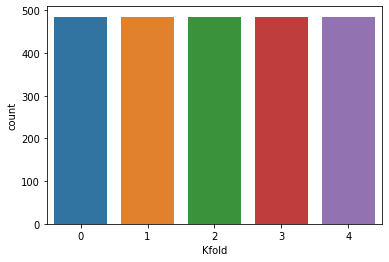

In [29]:
import seaborn as sns

sns.countplot(x='Kfold',data=train)

You can use sharded training plugin with any Lightning model by adding a single flag

# Use 8 GPUs, and enable Mixed Precision + Sharded Training

trainer = pl.Trainer(gpus=8, precision=16, max_epochs=50, accelerator='ddp', plugins='ddp_sharded')

In [32]:
dfx = train.copy()

In [81]:
import timm
timm.list_models()

['adv_inception_v3',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_vovnet39b',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ecaresnext26t_32x4d',
 'ecaresnext50t_32x4d',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b

In [82]:
#model_name = 'resnet152d'
model_name = "densenet121d"
def run(fold):

    check_path = model_name + "_" +str(fold)
    df_train = dfx[dfx.Kfold != fold].reset_index(drop=True)
    df_valid = dfx[dfx.Kfold == fold].reset_index(drop=True)

    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

    train_targets = F.one_hot(torch.tensor(df_train.label.values), num_classes=2) #only for binary cross entropy loss, you don't have to one hot for cross entropy
    valid_targets = F.one_hot(torch.tensor(df_valid.label.values), num_classes=2)

    train_dataset = Data(
        dataframe = df_train,
        transform = train_aug,
        target = train_targets
    )

    valid_dataset = Data(
        dataframe = df_valid,
        transform = valid_aug,
        target = valid_targets
    )

    checkpointer = ModelCheckpoint(
    monitor = 'validation_loss_epoch',
    dirpath = check_path,
    filename = 'resnet152d-{epoch:02d}-{val_loss_batch:2f}',
    mode = 'min',
    save_top_k = 1)

    early_stopping = EarlyStopping(
    monitor = 'validation_loss_epoch',
    patience = 5,
    mode = 'min')

    learning_rate_monitor = LearningRateMonitor(
    logging_interval = 'epoch')

    callbacks = [checkpointer, early_stopping, learning_rate_monitor]
    
      
    model = CNNClassifier(train_dataset, valid_dataset, learning_rate=5e-5, batch_size=16)

    trainer = pl.Trainer(
    auto_lr_find = True, #you can also try this to automatically find the learning rate, but in my case, this just didn't went well (the loss was diverging xD )
    # logger = comet_logger,
    callbacks = callbacks,
    max_epochs = 5,
    progress_bar_refresh_rate = 20,
    gpus = 1,
    # tpu_cores = 8, #for tpu, you have to also install some extra packages, a tutorial can be found on pytorch lightning docs
    accumulate_grad_batches=2, #gradient accumulation is recommended when you use bigger images, as you have to decrease the batch size to tackle the memory problem
    precision = 16,
    move_metrics_to_cpu = True #by default, lightning stores metric in gpu if you have cuda enabled, making this True, will make it to save on cpu, to conserve memory on GPU  
    )


    trainer.tune(model) #Uncomment if auto_lr_find is True


    # print(f"Current Learning rate of the model: {model.learning_rate:.4f}")


    trainer.fit(model)

    torch.save(model.state_dict(), f"{model_name}_final_fold_{fold}.pth")
    return model


In [48]:
model_0 = run(0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type   | Params
--------------------------------------------
0 | net              | NF_Net | 60.2 M
1 | train_acc_metric | F1     | 0     
2 | valid_acc_metric | F1     | 0     
--------------------------------------------
60.2 M    Trainable params
0         Non-trainable params
60.2 M    Total params
240.856   Total estimated model params size (MB)


Validation_ACC: 0.20270271599292755


Training_ACC: 0.49643468856811523
Validation_ACC: 0.6212098598480225
Training_ACC: 0.49364814162254333


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
Learning rate set to 0.000630957344480193
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type   | Params
--------------------------------------------
0 | net              | NF_Net | 60.2 M
1 | train_acc_metric | F1     | 0     
2 | valid_acc_metric | F1     | 0     
--------------------------------------------
60.2 M    Trainable params
0         Non-trainable params
60.2 M    Total params
240.856   Total estimated model params size (MB)


Validation_ACC: 0.6090561151504517


Training_ACC: 0.5401127934455872


Validation_ACC: 0.6591783761978149
Training_ACC: 0.572421133518219


Validation_ACC: 0.6794131994247437
Training_ACC: 0.590415358543396


Validation_ACC: 0.697699248790741
Training_ACC: 0.604749858379364


Validation_ACC: 0.702977180480957


## densenet121d

In [83]:
model_0 = run(0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type   | Params
--------------------------------------------
0 | net              | NF_Net | 60.2 M
1 | train_acc_metric | F1     | 0     
2 | valid_acc_metric | F1     | 0     
--------------------------------------------
60.2 M    Trainable params
0         Non-trainable params
60.2 M    Total params
240.856   Total estimated model params size (MB)


Validation_ACC: 0.3214285969734192


Training_ACC: 0.4961701035499573
Validation_ACC: 0.5939023494720459
Training_ACC: 0.49086126685142517


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
Learning rate set to 0.0009120108393559097
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type   | Params
--------------------------------------------
0 | net              | NF_Net | 60.2 M
1 | train_acc_metric | F1     | 0     
2 | valid_acc_metric | F1     | 0     
--------------------------------------------
60.2 M    Trainable params
0         Non-trainable params
60.2 M    Total params
240.856   Total estimated model params size (MB)


Validation_ACC: 0.5830249786376953


Training_ACC: 0.5404762029647827


Validation_ACC: 0.6386451125144958
Training_ACC: 0.5706793069839478


Validation_ACC: 0.6538764238357544
Training_ACC: 0.5892031192779541


Validation_ACC: 0.6713507175445557
Training_ACC: 0.5993514060974121


Validation_ACC: 0.6759023070335388


## Process Testdataset

In [64]:
class TestData(Dataset):
    def __init__(self, dataframe, transform):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, item):
      img_id = self.dataframe.iloc[item]['filename']
      img_path = img_path = "/content/content/pneumonia_dataset/test/"+img_id
      image = cv2.imread(img_path, 1)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      if self.transform is not None:
        image = self.transform(image = image)['image']

      return image

In [84]:
test_aug = albumentations.Compose([
            albumentations.Resize(384,384),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ), ToTensorV2(),
])

In [66]:
dfx_test = pd.read_csv("/content/content/pneumonia_dataset/test.csv")
print(dfx_test.head())
test_dataset = TestData(dataframe=dfx_test, transform=test_aug)

           filename
0  CXR_test_519.png
1  CXR_test_578.png
2  CXR_test_359.png
3  CXR_test_573.png
4  CXR_test_471.png


In [67]:
img1 = test_dataset.__getitem__(1)
img1.shape

torch.Size([3, 384, 384])

In [69]:
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle = False)

## Make predictions based on Folds

In [85]:
from tqdm import tqdm
final_preds = None
model_0.load_state_dict(torch.load("/content/densenet121d_final_fold_0.pth", map_location = "cuda"))
model_0.to("cuda")
for j in range(3):
    temp_preds = None
    model_0.eval()
    for batch in tqdm(test_dataloader):
      images = batch.cuda()
      preds = torch.sigmoid(model_0(images)).cpu().detach().numpy()
      if temp_preds is None:
          temp_preds = preds
      else:
          temp_preds = np.vstack((temp_preds, preds))
    
    if final_preds is None:
        final_preds = temp_preds
    else:
        final_preds += temp_preds
final_preds /= 3

100%|██████████| 38/38 [00:15<00:00,  2.45it/s]


##Fold 0

In [86]:
pred_proba_0 = final_preds
pred_model_0 = final_preds.argmax(axis = 1)

In [87]:
dfx_test['label'] = final_preds.argmax(axis = 1)

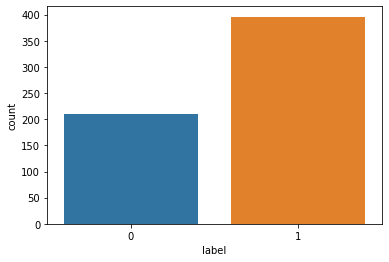

In [76]:
sns.countplot(x='label',data=dfx_test)

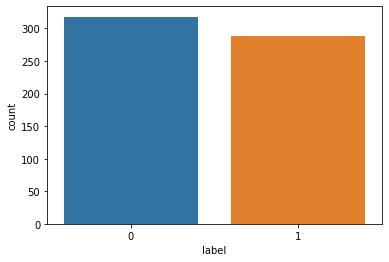

In [88]:
sns.countplot(x='label',data=dfx_test)

In [77]:
label_dict

{'normal': 0, 'pneumonia': 1}

In [89]:
dfx_test['label'] = dfx_test['label'].apply(lambda x : 'normal' if x == 0 else 'pneumonia')

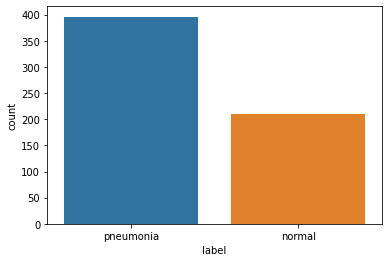

In [79]:
sns.countplot(x='label',data=dfx_test)


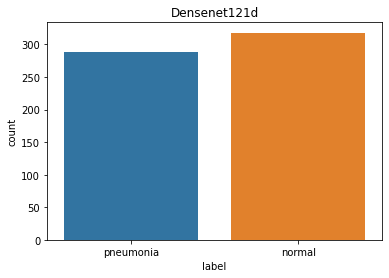

In [94]:
import matplotlib.pyplot as plt
sns.countplot(x='label',data=dfx_test)
plt.title("Densenet121d")
plt.show()

In [91]:
dfx_test.to_csv("lightning_densenet152.csv",index=False)

**Fold 0 5 epochs resnet152d - Submission successful! Your score is 66.28125568690893.**

**Fold 0 5 epochs densenet121d Submission successful! Your score is 70.39172081837503**